In [1]:
# ===== Cell 1: ライブラリインポート・設定 =====
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML関連ライブラリ
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
import xgboost as xgb

# 表示設定
plt.style.use('default')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

print("🚀 Phase 7: XGBoost電力需要予測モデル実装")
print("=" * 60)

🚀 Phase 7: XGBoost電力需要予測モデル実装


In [2]:
# ===== Cell 2: データロード・基本確認 =====
# データロード
data_path = "../../../data/ml/ml_features.csv"
df = pd.read_csv(data_path)

# 基本情報確認
print("=== データ基本情報 ===")
print(f"データ形状: {df.shape}")
print(f"期間: {df['date'].min()} 〜 {df['date'].max()}")
print(f"電力需要範囲: {df['actual_power'].min():.0f} 〜 {df['actual_power'].max():.0f} 万kW")
print()

# 欠損値確認（重要特徴量のみ）
important_cols = ['actual_power', 'temperature_2m', 'is_holiday', 'is_weekend', 
                  'lag_1_business_day', 'lag_1_day', 'hour_sin', 'hour_cos']
print("=== 重要特徴量の欠損値確認 ===")
for col in important_cols:
    if col in df.columns:
        null_count = df[col].isnull().sum()
        null_rate = null_count / len(df) * 100
        print(f"{col}: {null_count}個 ({null_rate:.1f}%)")

=== データ基本情報 ===
データ形状: (21984, 146)
期間: 2023-01-01 〜 2025-07-04
電力需要範囲: 1853 〜 5699 万kW

=== 重要特徴量の欠損値確認 ===
actual_power: 0個 (0.0%)
temperature_2m: 0個 (0.0%)
is_holiday: 0個 (0.0%)
is_weekend: 0個 (0.0%)
lag_1_business_day: 7128個 (32.4%)
lag_1_day: 24個 (0.1%)
hour_sin: 0個 (0.0%)
hour_cos: 0個 (0.0%)


In [3]:
# ===== Cell 3: データ型確認・前処理 =====
# date列を datetime型に変換
df['date'] = pd.to_datetime(df['date'])

# カテゴリカル変数の確認
print("=== カテゴリカル変数の確認 ===")
categorical_cols = ['day_of_week', 'is_weekend', 'is_holiday']
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")
    
# Boolean列の型変換
df['is_weekend'] = df['is_weekend'].astype(int)
df['is_holiday'] = df['is_holiday'].astype(int)

print("\n=== 前処理完了 ===")
print(f"最終データ形状: {df.shape}")

=== カテゴリカル変数の確認 ===
day_of_week: ['Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday']
is_weekend: [ True False]
is_holiday: [ True False]

=== 前処理完了 ===
最終データ形状: (21984, 146)


In [7]:
# ===== Cell 4: 特徴量グループ定義 =====
# カレンダー特徴量（ベースライン用）
calendar_features = [
    'hour', 'is_weekend', 'is_holiday', 'month',
    'hour_sin', 'hour_cos'
]

# 利用可能な特徴量の確認
print("=== 特徴量グループ定義 ===")
print("カレンダー特徴量:")
for feature in calendar_features:
    if feature in df.columns:
        print(f"  ✅ {feature}")
    else:
        print(f"  ❌ {feature} (存在しない)")

# 時系列特徴量の確認（後で使用）
lag_features = [col for col in df.columns if 'lag_' in col and 'business' in col]
print(f"\n営業日ベースラグ特徴量: {len(lag_features)}個確認")
print(f"例: {lag_features[:5]}")

# 気象特徴量の確認
weather_features = ['temperature_2m', 'relative_humidity_2m', 'precipitation']
print(f"\n気象特徴量: {len(weather_features)}個確認")

=== 特徴量グループ定義 ===
カレンダー特徴量:
  ✅ hour
  ✅ is_weekend
  ✅ is_holiday
  ✅ month
  ✅ hour_sin
  ✅ hour_cos

営業日ベースラグ特徴量: 30個確認
例: ['lag_1_business_day', 'lag_2_business_day', 'lag_3_business_day', 'lag_4_business_day', 'lag_5_business_day']

気象特徴量: 3個確認


In [8]:
# ===== 欠損値詳細分析 =====
print("=== 全特徴量の欠損値確認 ===")

# 欠損値のある列のみ表示
missing_summary = df.isnull().sum()
missing_cols = missing_summary[missing_summary > 0].sort_values(ascending=False)

if len(missing_cols) > 0:
    print("欠損値のある特徴量:")
    for col, missing_count in missing_cols.items():
        missing_rate = missing_count / len(df) * 100
        print(f"  {col}: {missing_count:,}個 ({missing_rate:.1f}%)")
else:
    print("✅ 欠損値のある特徴量はありません")

print(f"\n=== ラグ特徴量の欠損パターン分析 ===")
# 営業日ベースラグの欠損確認
business_lag_cols = [col for col in df.columns if 'lag_' in col and 'business' in col][:5]
for col in business_lag_cols:
    missing_count = df[col].isnull().sum()
    missing_rate = missing_count / len(df) * 100
    print(f"{col}: {missing_count:,}個 ({missing_rate:.1f}%)")

# 全日ベースラグの欠損確認
print(f"\n=== 全日ベースラグの欠損 ===")
day_lag_cols = [col for col in df.columns if 'lag_' in col and 'business' not in col][:5]
for col in day_lag_cols:
    missing_count = df[col].isnull().sum()
    missing_rate = missing_count / len(df) * 100
    print(f"{col}: {missing_count:,}個 ({missing_rate:.1f}%)")

=== 全特徴量の欠損値確認 ===
欠損値のある特徴量:
  lag_30_business_day: 7,824個 (35.6%)
  change_rate_30_business_day: 7,824個 (35.6%)
  change_rate_29_business_day: 7,800個 (35.5%)
  lag_29_business_day: 7,800個 (35.5%)
  lag_28_business_day: 7,776個 (35.4%)
  change_rate_28_business_day: 7,776個 (35.4%)
  change_rate_27_business_day: 7,752個 (35.3%)
  lag_27_business_day: 7,752個 (35.3%)
  lag_26_business_day: 7,728個 (35.2%)
  change_rate_26_business_day: 7,728個 (35.2%)
  change_rate_25_business_day: 7,704個 (35.0%)
  lag_25_business_day: 7,704個 (35.0%)
  lag_24_business_day: 7,680個 (34.9%)
  change_rate_24_business_day: 7,680個 (34.9%)
  change_rate_23_business_day: 7,656個 (34.8%)
  lag_23_business_day: 7,656個 (34.8%)
  lag_22_business_day: 7,632個 (34.7%)
  change_rate_22_business_day: 7,632個 (34.7%)
  change_rate_21_business_day: 7,608個 (34.6%)
  lag_21_business_day: 7,608個 (34.6%)
  lag_20_business_day: 7,584個 (34.5%)
  change_rate_20_business_day: 7,584個 (34.5%)
  change_rate_19_business_day: 7,560個 (34.4%)


In [9]:
# ===== データ期間の詳細確認 =====
print("=== データ期間の詳細確認 ===")

# 最新・最古の日付
print(f"データ開始日: {df['date'].min()}")
print(f"データ終了日: {df['date'].max()}")
print(f"データ総日数: {(pd.to_datetime(df['date'].max()) - pd.to_datetime(df['date'].min())).days + 1}日")

# 最新数日のデータ確認
print(f"\n=== 最新5日間の確認 ===")
latest_dates = df['date'].unique()
latest_dates = sorted(latest_dates)[-5:]  # 最新5日

for date in latest_dates:
    record_count = len(df[df['date'] == date])
    print(f"{date}: {record_count}レコード")

# 最新日の詳細
latest_date = df['date'].max()
latest_data = df[df['date'] == latest_date]
print(f"\n=== 最新日（{latest_date}）の詳細 ===")
print(f"レコード数: {len(latest_data)}")
print(f"時間範囲: {latest_data['hour'].min()}時 〜 {latest_data['hour'].max()}時")
print(f"電力需要範囲: {latest_data['actual_power'].min():.0f} 〜 {latest_data['actual_power'].max():.0f} 万kW")

=== データ期間の詳細確認 ===
データ開始日: 2023-01-01 00:00:00
データ終了日: 2025-07-04 00:00:00
データ総日数: 916日

=== 最新5日間の確認 ===
2025-06-30 00:00:00: 24レコード
2025-07-01 00:00:00: 24レコード
2025-07-02 00:00:00: 24レコード
2025-07-03 00:00:00: 24レコード
2025-07-04 00:00:00: 24レコード

=== 最新日（2025-07-04 00:00:00）の詳細 ===
レコード数: 24
時間範囲: 0時 〜 23時
電力需要範囲: 2682 〜 4991 万kW


In [10]:
# ===== Cell 5: 複数期間予測用データ分割（調整版） =====
print("=== 複数期間予測用データ分割 ===")

# 期間定義
one_week_test_start = '2025-06-28'   # 1週間予測：6/28〜7/4（7日間）
one_month_test_start = '2025-06-01'  # 1ヶ月予測：6月全体（30日間）
one_month_test_end = '2025-07-01'    # 6月末まで

# 1週間予測用データ分割
train_data_week = df[df['date'] < one_week_test_start]
test_data_week = df[df['date'] >= one_week_test_start]

# 1ヶ月予測用データ分割（6月のみ）
train_data_month = df[df['date'] < one_month_test_start]
test_data_month = df[(df['date'] >= one_month_test_start) & (df['date'] < one_month_test_end)]

print("=== 1週間予測設定 ===")
print(f"テスト期間: {test_data_week['date'].min()} 〜 {test_data_week['date'].max()}")
print(f"テストデータ: {len(test_data_week)}レコード（{len(test_data_week)//24}日間）")
print(f"訓練データ: {len(train_data_week):,}レコード")

print("\n=== 1ヶ月予測設定（6月全体） ===")
print(f"テスト期間: {test_data_month['date'].min()} 〜 {test_data_month['date'].max()}")
print(f"テストデータ: {len(test_data_month)}レコード（{len(test_data_month)//24}日間）")
print(f"訓練データ: {len(train_data_month):,}レコード")

print("\n=== 評価戦略 ===")
print("🎯 1週間予測: 最新1週間（6/28-7/4）")
print("🎯 1ヶ月予測: 6月全体（6/1-6/30）")
print("🎯 比較分析: 短期vs中期予測精度")

=== 複数期間予測用データ分割 ===
=== 1週間予測設定 ===
テスト期間: 2025-06-28 00:00:00 〜 2025-07-04 00:00:00
テストデータ: 168レコード（7日間）
訓練データ: 21,816レコード

=== 1ヶ月予測設定（6月全体） ===
テスト期間: 2025-06-01 00:00:00 〜 2025-06-30 00:00:00
テストデータ: 720レコード（30日間）
訓練データ: 21,168レコード

=== 評価戦略 ===
🎯 1週間予測: 最新1週間（6/28-7/4）
🎯 1ヶ月予測: 6月全体（6/1-6/30）
🎯 比較分析: 短期vs中期予測精度


In [11]:
# ===== Cell 6: カレンダー特徴量ベースライン（1週間予測） =====
print("=== カレンダー特徴量ベースライン構築 ===")

# カレンダー特徴量定義
calendar_features = ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos']

# 1週間予測用データ準備
X_train_cal = train_data_week[calendar_features]
y_train_week = train_data_week['actual_power']
X_test_cal = test_data_week[calendar_features]
y_test_week = test_data_week['actual_power']

print(f"学習用特徴量: {X_train_cal.shape}")
print(f"テスト用特徴量: {X_test_cal.shape}")

# XGBoostベースラインモデル
xgb_baseline = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

print("\n=== モデル学習中 ===")
xgb_baseline.fit(X_train_cal, y_train_week)

# 予測実行
y_pred_baseline = xgb_baseline.predict(X_test_cal)

# 評価指標計算
mape_week = mean_absolute_percentage_error(y_test_week, y_pred_baseline) * 100
mae_week = mean_absolute_error(y_test_week, y_pred_baseline)
r2_week = r2_score(y_test_week, y_pred_baseline)

print(f"\n=== 1週間予測ベースライン結果 ===")
print(f"🎯 MAPE: {mape_week:.2f}%")
print(f"📊 MAE: {mae_week:.0f} 万kW")
print(f"📈 R²: {r2_week:.4f}")

# 目標達成度確認
target_mape = 12.0  # 目標MAPE
if mape_week <= target_mape:
    print(f"✅ 目標MAPE {target_mape}%を達成！")
else:
    print(f"⚠️ 目標MAPE {target_mape}%まで {mape_week-target_mape:.1f}%改善が必要")

=== カレンダー特徴量ベースライン構築 ===
学習用特徴量: (21816, 6)
テスト用特徴量: (168, 6)

=== モデル学習中 ===

=== 1週間予測ベースライン結果 ===
🎯 MAPE: 7.06%
📊 MAE: 256 万kW
📈 R²: 0.7940
✅ 目標MAPE 12.0%を達成！


In [12]:
# ===== Cell 7: 時系列特徴量追加モデル ===
print("=== 時系列特徴量追加モデル ===")

# 全特徴量定義（段階的追加）
calendar_features = ['hour', 'is_weekend', 'is_holiday', 'month', 'hour_sin', 'hour_cos']
lag_features = ['lag_1_day', 'lag_7_day', 'lag_1_business_day']  # 欠損の少ない重要ラグ
weather_features = ['temperature_2m', 'relative_humidity_2m', 'precipitation']

# 全特徴量統合
all_features = calendar_features + lag_features + weather_features

print(f"使用特徴量: {len(all_features)}個")
print(f"カレンダー: {len(calendar_features)}個")
print(f"時系列: {len(lag_features)}個") 
print(f"気象: {len(weather_features)}個")

# データ準備
X_train_full = train_data_week[all_features]
X_test_full = test_data_week[all_features]

# 欠損値確認
print(f"\n=== 特徴量欠損値確認 ===")
for feature in lag_features:
    missing_train = X_train_full[feature].isnull().sum()
    missing_test = X_test_full[feature].isnull().sum()
    print(f"{feature}: 訓練{missing_train}個, テスト{missing_test}個")

# XGBoost全特徴量モデル
xgb_full = xgb.XGBRegressor(
    n_estimators=200,      # より多くの木
    max_depth=8,           # より深い木
    learning_rate=0.05,    # より慎重な学習
    random_state=42,
    verbosity=0
)

print("\n=== 全特徴量モデル学習中 ===")
xgb_full.fit(X_train_full, y_train_week)

# 予測・評価
y_pred_full = xgb_full.predict(X_test_full)

mape_full = mean_absolute_percentage_error(y_test_week, y_pred_full) * 100
mae_full = mean_absolute_error(y_test_week, y_pred_full)
r2_full = r2_score(y_test_week, y_pred_full)

print(f"\n=== 全特徴量モデル結果 ===")
print(f"🎯 MAPE: {mape_full:.2f}%")
print(f"📊 MAE: {mae_full:.0f} 万kW")
print(f"📈 R²: {r2_full:.4f}")

print(f"\n=== 改善度 ===")
print(f"MAPE改善: {mape_week:.2f}% → {mape_full:.2f}% ({mape_week-mape_full:.2f}%改善)")
print(f"R²改善: {r2_week:.4f} → {r2_full:.4f} ({r2_full-r2_week:.4f}改善)")

=== 時系列特徴量追加モデル ===
使用特徴量: 12個
カレンダー: 6個
時系列: 3個
気象: 3個

=== 特徴量欠損値確認 ===
lag_1_day: 訓練24個, テスト0個
lag_7_day: 訓練168個, テスト0個
lag_1_business_day: 訓練7080個, テスト48個

=== 全特徴量モデル学習中 ===

=== 全特徴量モデル結果 ===
🎯 MAPE: 2.33%
📊 MAE: 85 万kW
📈 R²: 0.9803

=== 改善度 ===
MAPE改善: 7.06% → 2.33% (4.74%改善)
R²改善: 0.7940 → 0.9803 (0.1863改善)


=== Feature Importance分析 ===
=== 特徴量重要度ランキング ===
 1. lag_1_day           : 0.5490
 2. lag_1_business_day  : 0.2876
 3. temperature_2m      : 0.0431
 4. is_weekend          : 0.0398
 5. hour_cos            : 0.0190
 6. hour_sin            : 0.0179
 7. hour                : 0.0102
 8. lag_7_day           : 0.0086
 9. precipitation       : 0.0085
10. month               : 0.0063
11. is_holiday          : 0.0060
12. relative_humidity_2m: 0.0040

=== カテゴリ別重要度 ===
📅 カレンダー特徴量: 0.099 (9.9%)
⏰ 時系列特徴量: 0.845 (84.5%)
🌤️ 気象特徴量: 0.056 (5.6%)


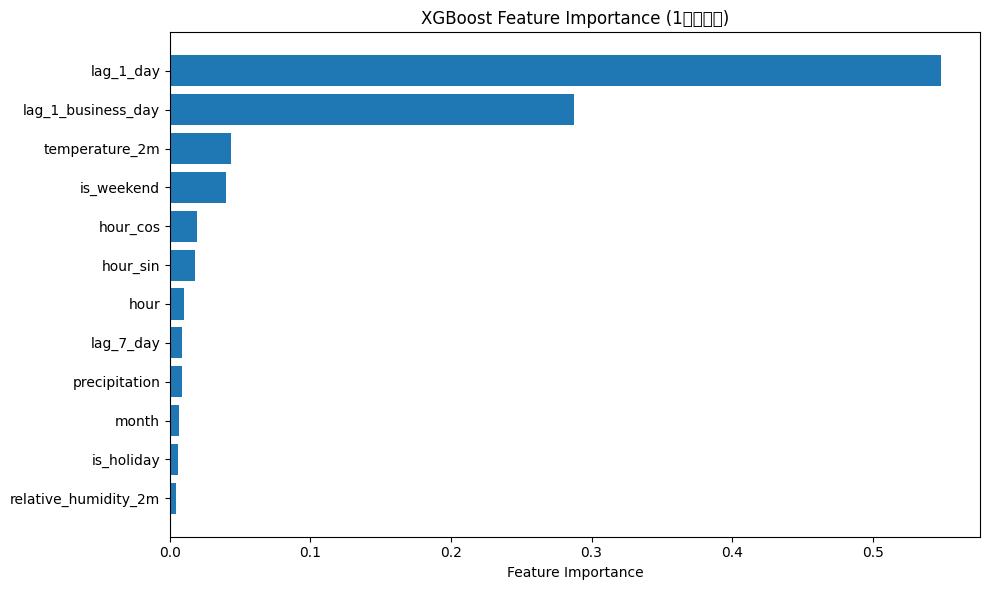

In [13]:
# ===== Cell 8: Feature Importance分析 =====
print("=== Feature Importance分析 ===")

# 特徴量重要度取得
feature_importance = xgb_full.feature_importances_
feature_names = all_features

# 重要度をDataFrameで整理
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("=== 特徴量重要度ランキング ===")
for i, (_, row) in enumerate(importance_df.iterrows()):
    print(f"{i+1:2d}. {row['feature']:20s}: {row['importance']:.4f}")

# 特徴量カテゴリ別重要度
calendar_importance = importance_df[importance_df['feature'].isin(calendar_features)]['importance'].sum()
lag_importance = importance_df[importance_df['feature'].isin(lag_features)]['importance'].sum()
weather_importance = importance_df[importance_df['feature'].isin(weather_features)]['importance'].sum()

print(f"\n=== カテゴリ別重要度 ===")
print(f"📅 カレンダー特徴量: {calendar_importance:.3f} ({calendar_importance*100:.1f}%)")
print(f"⏰ 時系列特徴量: {lag_importance:.3f} ({lag_importance*100:.1f}%)")
print(f"🌤️ 気象特徴量: {weather_importance:.3f} ({weather_importance*100:.1f}%)")

# 可視化
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance (1週間予測)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [14]:
# ===== Cell 9: 1ヶ月予測での検証 =====
print("=== 1ヶ月予測（6月全体）での検証 ===")

# 1ヶ月予測用データ準備
X_train_month = train_data_month[all_features]
y_train_month = train_data_month['actual_power']
X_test_month = test_data_month[all_features]
y_test_month = test_data_month['actual_power']

print(f"1ヶ月予測用データ: 訓練{len(X_train_month):,}件, テスト{len(X_test_month)}件")

# 同じモデル設定で学習
xgb_month = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    random_state=42,
    verbosity=0
)

xgb_month.fit(X_train_month, y_train_month)
y_pred_month = xgb_month.predict(X_test_month)

# 評価
mape_month = mean_absolute_percentage_error(y_test_month, y_pred_month) * 100
mae_month = mean_absolute_error(y_test_month, y_pred_month)
r2_month = r2_score(y_test_month, y_pred_month)

print(f"\n=== 1ヶ月予測結果 ===")
print(f"🎯 MAPE: {mape_month:.2f}%")
print(f"📊 MAE: {mae_month:.0f} 万kW")
print(f"📈 R²: {r2_month:.4f}")

print(f"\n=== 予測期間比較 ===")
print(f"1週間予測: MAPE {mape_full:.2f}%, R² {r2_full:.4f}")
print(f"1ヶ月予測: MAPE {mape_month:.2f}%, R² {r2_month:.4f}")

=== 1ヶ月予測（6月全体）での検証 ===
1ヶ月予測用データ: 訓練21,168件, テスト720件

=== 1ヶ月予測結果 ===
🎯 MAPE: 2.79%
📊 MAE: 90 万kW
📈 R²: 0.9692

=== 予測期間比較 ===
1週間予測: MAPE 2.33%, R² 0.9803
1ヶ月予測: MAPE 2.79%, R² 0.9692
